In [1]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells, extend_spells, gb_index
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import DataHandler, open_da, data_path, compute_anomalies_pl, coarsen_da, compute_anomalies_ds
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    PRETTIER_VARNAME,
    YEARS,
    KAPPA,
    compute,
    get_region,
    infer_direction,
    polars_to_xarray,
    xarray_to_polars,
    labels_to_mask,
    extract_season_from_df,
    DUNCANS_REGIONS_NAMES,
    UNITS,
    N_WORKERS,
    do_rle,
    do_rle_fill_hole,
)
from jetutils.jet_finding import JetFindingExperiment, jet_integral_haversine, find_all_jets, haversine_from_dl, jet_position_as_da, add_normals, gather_normal_da_jets, average_jet_categories, connected_from_cross, get_double_jet_index, iterate_over_year_maybe_member
from jetutils.plots import COLORS, COLORS_EXT, PINKPURPLE, Clusterplot, gather_normal_da_jets_wrapper, _gather_normal_da_jets_wrapper, make_transparent, honeycomb_panel, plot_seasonal, interp_jets_to_zero_one
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from tqdm import tqdm
import polars.selectors as cs


%load_ext autoreload
%autoreload 2
%matplotlib inline

Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  10
Guessed MEMORY_LIMIT :  225280


In [2]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    labels = labels.cast({"time": pl.Datetime("ms")})
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)

In [ ]:
dh = DataHandler.from_specs("ERA5", "plev", "high_wind", "6H", "all", None, -80, 40, 15, 90)
exp = JetFindingExperiment(dh)
all_jets_one_df = exp.find_jets(force=False, alignment_thresh=0.6, base_s_thresh=0.55, int_thresh_factor=0.3, hole_size=10)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=5, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
props_as_df = exp.props_as_df(True).cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})
props_anom = compute_anomalies_pl(props_as_df, standardize=True, smooth_clim=61)
summer_filter = summer.rename("time").to_frame()
props_summer = summer_filter.join(props_as_df, on="time")
ds = exp.ds

In [4]:
cross, summary_comp = exp.track_jets(
    dist_thresh=1.2,
    overlap_min_thresh=0.6,
    overlap_max_thresh=0.7,
    dis_polar_thresh=0.2,
    force=0,
    n_next=3,
)

In [5]:
def pdf(col) -> pl.Expr:
    return pl.col(col).unique_counts().cum_sum() / pl.col(col).unique_counts().sum()


def create_spells_list(
    all_jets_one_df: pl.DataFrame,
    props_uncat: pl.DataFrame,
    cross: pl.DataFrame,
    summer: pl.Series,
    dist_thresh: float = 2,
    overlap_min_thresh: float = 0.5,
    overlap_max_thresh: float = 0.6,
    dis_polar_thresh: float | None = 1.0,
    is_polar_cutoff: float = 0.9,
    len_quantile: float = 0.95,
):
    a, b = np.histogram(props_uncat["is_polar"])
    c = (b[:-1] + b[1:]) / 2
    filter_ = (c > 0.2) & (c < 0.8)
    cutoff = c[np.argmax(filter_) + np.argmin(a[filter_])]

    props_as_df = average_jet_categories(props_uncat, cutoff)
    summer_filter = summer.rename("time").to_frame()
    props_summer = summer_filter.join(props_as_df, on="time")

    cross_upd, summary_comp = connected_from_cross(
        all_jets_one_df,
        cross,
        dist_thresh,
        overlap_min_thresh,
        overlap_max_thresh,
        dis_polar_thresh,
    )
    summary_comp = summary_comp.filter(pl.col("len") > 1).with_columns(
        spell=pl.col("spell").rle_id()
    )

    summary_comp = summary_comp.with_columns(
        **{
            "spell_of": pl.when(pl.col("is_polar") > cutoff)
            .then(pl.lit("EDJ"))
            .otherwise(pl.lit("STJ"))
        }
    )
    which = pl.col("overlap_min").fill_null(0).arg_max()
    summary_comp = summary_comp.with_columns(
        relative_time=(pl.col("time") - pl.col("time").first()).over("spell")
    )
    summary_comp = summary_comp.with_columns(
        relative_index=(
            pl.col("relative_time")
            / pl.col("relative_time").filter(pl.col("relative_time") > 0).min()
        ).cast(pl.Int32())
    )
    # summary_comp = (
    #     summary_comp
    #     .group_by(["spell", "relative_index", "jet ID"])
    #     .agg(pl.all().get(which))
    # )
    summary_comp_summer = summary_comp.filter(
        pl.col("time").is_in(summer.implode()).all().over("spell")
    )
    summary_comp_summer_stj = summary_comp_summer.filter(
        (pl.col("spell_of") == "STJ").mean().over("spell") > is_polar_cutoff
    )
    summary_comp_summer_edj = summary_comp_summer.filter(
        (pl.col("spell_of") == "EDJ").mean().over("spell") > is_polar_cutoff
    )
    spells_list = {}
    spells_list["EDJ"] = (
        summary_comp_summer_edj.join(
            summary_comp_summer_edj.unique("spell").select(
                pl.col("len").unique(), pdf=pdf("len")
            ),
            on="len",
        )
        .filter(pl.col("pdf") > len_quantile)
    )
    spells_list["STJ"] = (
        summary_comp_summer_stj.join(
            summary_comp_summer_stj.unique("spell").select(
                pl.col("len").unique(), pdf=pdf("len")
            ),
            on="len",
        )
        .filter(pl.col("pdf") > len_quantile)
    )
    return cross_upd, spells_list, props_summer

## Props

In [8]:
# TODO: make it also do prop anomalies
def figures(
    all_jets_one_df: pl.DataFrame,
    props_uncat: pl.DataFrame,
    cross: pl.DataFrame,
    summer: pl.Series,
    dist_thresh: float = 2,
    overlap_min_thresh: float = 0.5,
    overlap_max_thresh: float = 0.6,
    dis_polar_thresh: float | None = 1.0,
    is_polar_cutoff: float = 0.9,
    len_quantile: float = 0.95,
):

    cross_upd, spells_list, props_summer = create_spells_list(
        all_jets_one_df,
        props_uncat,
        cross,
        summer,
        dist_thresh,
        overlap_min_thresh,
        overlap_max_thresh,
        dis_polar_thresh,
        is_polar_cutoff,
        len_quantile,
    )
    plt.style.use("default")
    plt.rc("xtick", labelsize=14)
    plt.rc("ytick", labelsize=14)
    plt.rc("axes", labelsize=14)
    plt.rc("axes", titlesize=14)
    plt.rc("font", size=14)
    plt.rc("text", usetex=False)
    plt.rc("savefig", dpi=300)
    plt.rc("savefig", bbox="tight")

    spells_from_jet = spells_list["STJ"]
    print("STJ:", spells_from_jet["spell"].n_unique(), "spells")
    props_masked = mask_from_spells_pl(
        spells_from_jet.drop("is_polar"),
        props_summer,
        time_before=datetime.timedelta(days=4),
    )
    data_vars = [
        "mean_lon",
        "mean_lat",
        "mean_s",
        "width",
        "tilt",
        "waviness1",
        "wavinessDC16",
        "int",
        "is_polar",
    ]
    aggs = {col: pl.col(col).mean() for col in data_vars}
    aggs = aggs | {"alive": pl.col("time").len()}
    mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
        **aggs
    )
    aggs = {col: pl.col(col).quantile(0.25) for col in data_vars}
    q25 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
        **aggs
    )
    aggs = {col: pl.col(col).quantile(0.75) for col in data_vars}
    q75 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
        **aggs
    )
    fig1, axes = plt.subplots(3, 3, figsize=(12, 12), tight_layout=False)
    axes = axes.ravel()

    means = props_summer.group_by("jet", maintain_order=True).mean()
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("jet") == jet)
        q25_ = q25.filter(pl.col("jet") == jet)
        q75_ = q75.filter(pl.col("jet") == jet)
        x = to_plot["relative_index"].unique().to_numpy()
        for ax, data_var in zip(axes, data_vars):
            factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
            factor = 1e5 if data_var == "width" else factor
            ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
            ax.fill_between(
                x,
                q25_[data_var] / factor,
                q75_[data_var] / factor,
                color=COLORS[2 - j],
                alpha=0.4,
            )
            mean = means.filter(pl.col("jet") == jet)[data_var].item() / factor
            ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
            if j == 0:
                factor_str = (
                    "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
                )
                ax.set_title(
                    rf"{PRETTIER_VARNAME.get(data_var, data_var)} [{factor_str}{UNITS.get(data_var, '')}]"
                )
            ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
    for i, ax in enumerate(axes):
        ax.axvline(0, zorder=1, color="black", lw=2)
        ax.set_xlabel("Relative time around onset [days]", color="black")
    fig1.set_tight_layout(True)

    spells_from_jet = spells_list["EDJ"]
    print("EDJ:", spells_from_jet["spell"].n_unique(), "spells")

    props_masked = mask_from_spells_pl(
        spells_from_jet.drop("is_polar"),
        props_summer,
        time_before=datetime.timedelta(days=4),
    )

    aggs = {col: pl.col(col).mean() for col in data_vars}
    aggs = aggs | {"alive": pl.col("time").len()}
    mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
        **aggs
    )
    aggs = {col: pl.col(col).quantile(0.25) for col in data_vars}
    q25 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
        **aggs
    )
    aggs = {col: pl.col(col).quantile(0.75) for col in data_vars}
    q75 = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
        **aggs
    )
    fig2, axes = plt.subplots(3, 3, figsize=(12, 12), tight_layout=False)
    axes = axes.ravel()
    means = props_summer.group_by("jet", maintain_order=True).mean()
    for j, jet in enumerate(["STJ", "EDJ"]):
        to_plot = mean_ps.filter(pl.col("jet") == jet)
        q25_ = q25.filter(pl.col("jet") == jet)
        q75_ = q75.filter(pl.col("jet") == jet)
        x = to_plot["relative_index"].unique().to_numpy()
        for ax, data_var in zip(axes, data_vars):
            factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
            factor = 1e5 if data_var == "width" else factor
            ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
            ax.fill_between(
                x,
                q25_[data_var] / factor,
                q75_[data_var] / factor,
                color=COLORS[2 - j],
                alpha=0.4,
            )
            mean = means.filter(pl.col("jet") == jet)[data_var].item() / factor
            ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
            if j == 0:
                factor_str = (
                    "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
                )
                ax.set_title(
                    rf"{PRETTIER_VARNAME.get(data_var, data_var)} [{factor_str}{UNITS.get(data_var, '')}]"
                )
            ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
    for i, ax in enumerate(axes):
        ax.axvline(0, zorder=1, color="black", lw=2)
        ax.set_xlabel("Relative time around onset [days]", color="black")
    fig2.set_tight_layout(True)
    return fig1, fig2

STJ: 27 spells
EDJ: 37 spells


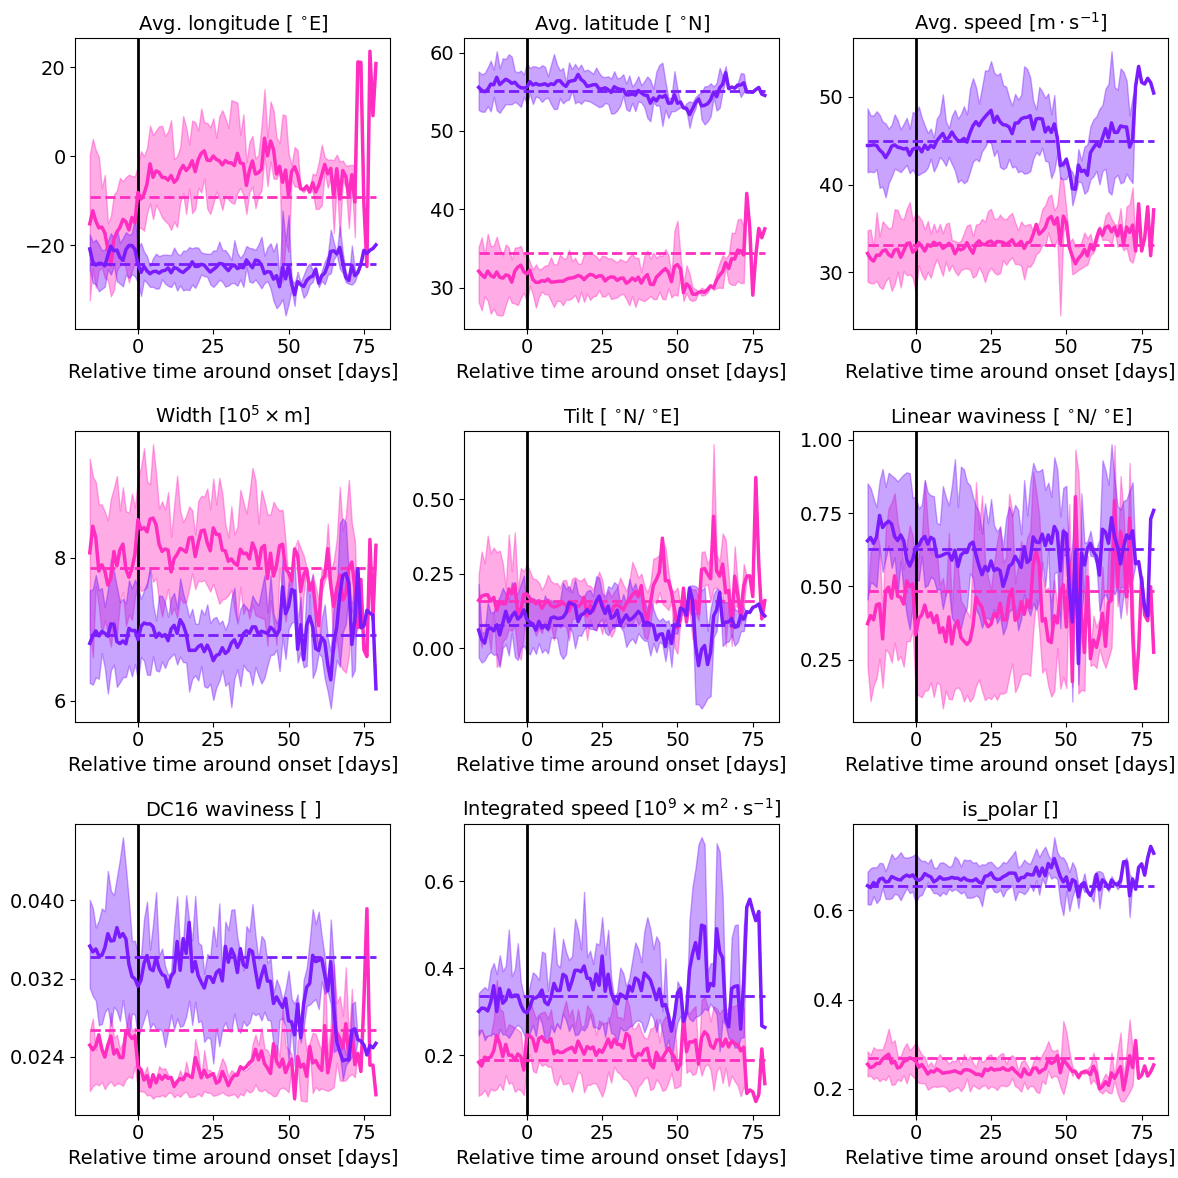

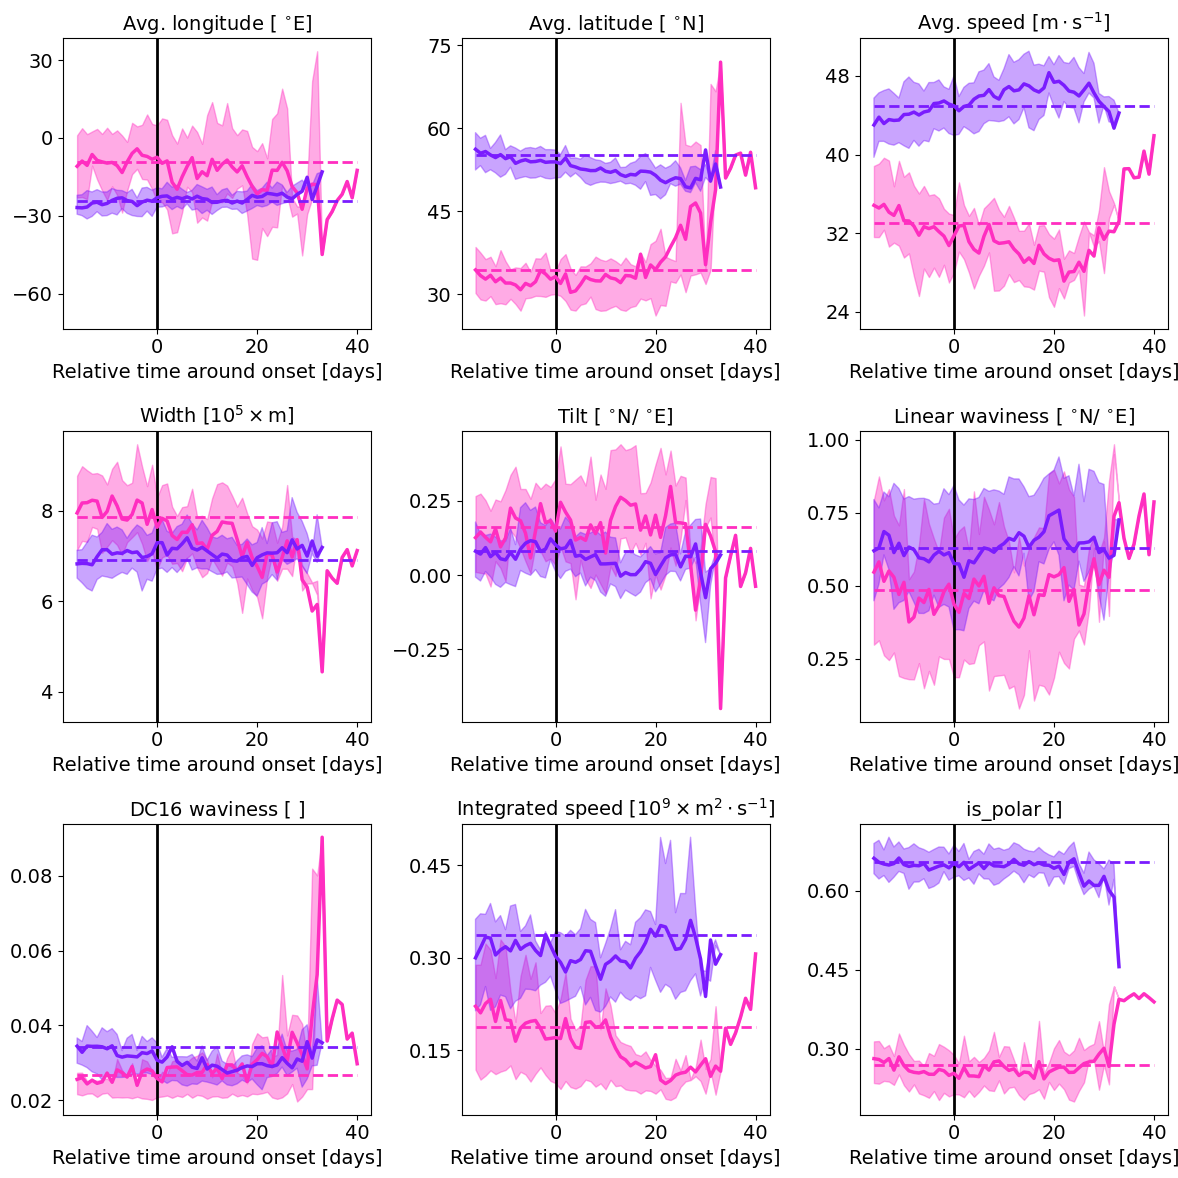

In [12]:
hohohoohohooho = figures(
    all_jets_one_df,
    props_uncat, 
    cross, 
    summer,
    dist_thresh=1.4,
    overlap_min_thresh=0.5,
    overlap_max_thresh=0.7,
    dis_polar_thresh=0.4,
    is_polar_cutoff=0.8,
    len_quantile=0.985
)

# Jet relative stuff

In [6]:
args = ["all", None, *get_region(ds), "all"]
da_T = open_da(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args,
)
da_T = compute(da_T.sel(time=summer_daily), progress_flag=True)
da_T_upper = open_da(
    "ERA5",
    "plev",
    "t300",
    "dailymean",
    *args,
)
da_T_upper = compute(da_T_upper.sel(time=summer_daily), progress_flag=True)
da_tp = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    *args,
)
da_tp = compute(da_tp.sel(time=summer_daily), progress_flag=True)
da_apvs = open_da(
    "ERA5",
    "thetalev",
    "apvs",
    "dailyany",
    *args,
)
da_apvs = compute(da_apvs.sel(time=summer_daily), progress_flag=True)
da_cpvs = open_da(
    "ERA5",
    "thetalev",
    "cpvs",
    "dailyany",
    *args,
)
da_cpvs = compute(da_cpvs.sel(time=summer_daily), progress_flag=True)

# args = ["all", None, *get_region(ds), "all", "dayofyear", {"dayofyear": ("win", 15)}]
# da_T_anom = open_da(
#     "ERA5",
#     "surf",
#     "t2m",
#     "dailymean",
#     *args
# )
# da_T_anom = compute(da_T_anom.sel(time=summer_daily), progress_flag=True)
# da_tp_anom = open_da(
#     "ERA5",
#     "surf",
#     "tp",
#     "dailysum",
#     *args
# )
# da_tp_anom = compute(da_tp_anom.sel(time=summer_daily), progress_flag=True)

[########################################] | 100% Completed | 18.20 s
[########################################] | 100% Completed | 22.13 s
[########################################] | 100% Completed | 20.42 s
[########################################] | 100% Completed | 3.52 sms
[########################################] | 100% Completed | 3.52 sms


In [42]:
from jetutils.anyspell import make_daily

def symmetrize_p(
    pvals: xr.DataArray | np.ndarray, direction: int, q: float
) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"

        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets, times, da, n_bootstraps=n_bootstraps, clim=clim
        )
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds

        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
            to_plot.quantile(0.01), to_plot.quantile(0.99)
        )
        norm = BoundaryNorm(levels, cmap.N)

        axes[0].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        axes[1].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs


cross_upd, spells_list, _ = create_spells_list(
    all_jets_one_df,
    props_uncat, 
    cross, 
    summer,
    dist_thresh=4.,
    overlap_min_thresh=0.4,
    overlap_max_thresh=0.6,
    dis_polar_thresh=0.4,
    is_polar_cutoff=0.8,
    len_quantile=0.99
)
spells_list = {a: b.with_columns(spell2=pl.col("spell").rle_id()) for a, b in spells_list.items()}
kwargs = dict(time_before=datetime.timedelta(hours=24), time_after=datetime.timedelta(hours=24))

daily_spells_list = {a: make_daily(b, "spell", ["spell2", "len", "pdf", "spell_of"]) for a, b in spells_list.items()}
# spells_list = {a: extend_spells(b, **kwargs) for a, b in spells_list.items()}


clims = {
    "t2m": xr.open_dataarray(exp.path.joinpath("t2m_relative_clim.nc")),
    "t_up": xr.open_dataarray(exp.path.joinpath("t300_relative_clim.nc")),
    "tp": xr.open_dataarray(exp.path.joinpath("tp_relative_clim.nc")),
    "apvs" : xr.open_dataarray(exp.path.joinpath("apvs_relative_clim.nc")),
    "cpvs": xr.open_dataarray(exp.path.joinpath("cpvs_relative_clim.nc")),
}

variable_dict = {
    "t2m": [da_T, 8, colormaps.BlWhRe, [-4, 4]],
    "t_up": [da_T_upper, 8, colormaps.BlWhRe, [-4, 4]],
    "tp": [da_tp * 1000, 15, colormaps.precip4_diff_19lev, [-4, 4]],
    "apvs": [da_apvs * 100, 8, colormaps.curl, [-40, 40]],
    "cpvs": [da_cpvs * 100, 8, colormaps.curl, [-40, 40]],
}
long_names = {
    "t2m": "2m temperature [K]",
    "t_up": "Upper level temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)
from itertools import product

In [56]:
cross_upd, spells_list, _ = create_spells_list(
    all_jets_one_df,
    props_uncat, 
    cross, 
    summer,
    dist_thresh=10,
    overlap_min_thresh=0.5,
    overlap_max_thresh=0.9,
    dis_polar_thresh=0.4,
    is_polar_cutoff=0.8,
    len_quantile=0.1,
)
spells_list = {a: b.with_columns(spell2=pl.col("spell").rle_id()) for a, b in spells_list.items()}
daily_spells_list = {a: make_daily(b, "spell", ["spell2", "len", "pdf", "spell_of"]) for a, b in spells_list.items()}

huh = spells_list["EDJ"].group_by("spell2", maintain_order=True).agg(pers=(1 / pl.col("vert_dist").replace(0, 0.1)).sum(), overlap=pl.col("overlap_max").sum(), len=pl.col("len").first())

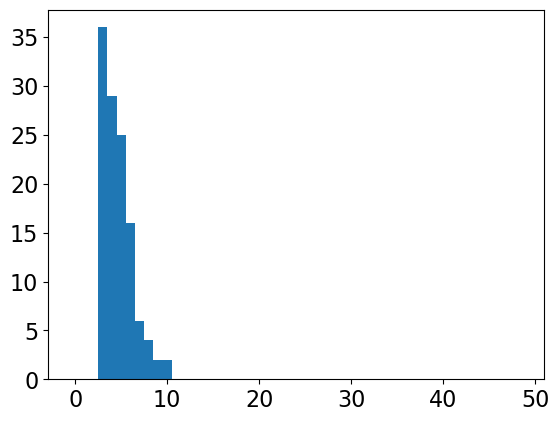

In [ ]:
_ = plt.hist(huh.with_columns(pdf_pers=pdf("pers")).filter(pl.col("pdf_pers") > 0.1)["len"], bins=np.arange(50) - 0.5)

In [ ]:

basepath = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp")
basepath_clim = Path("/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_clims")
import os
for file in basepath.glob("*.nc"):
    os.remove(file)

n_bootstraps = 1
for spells_of in ["STJ", "EDJ"]:
    spells_from_jet = daily_spells_list[spells_of]
    spells_from_jet = extend_spells(spells_from_jet, time_before=datetime.timedelta(days=1))
    spells_from_jet = subset_around_onset(spells_from_jet, around_onset=datetime.timedelta(days=1))
    jets = summer_daily.rename("time").to_frame().join(all_jets_one_df, on="time")
    times = spells_from_jet
    for i, (varname, props) in enumerate(variable_dict.items()):
        da, nlevels, cmap, (min_, max_) = props
        clim = clims[varname]
        hatch = "xxx"
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets.cast({"time": pl.Datetime("ms")}), times, da, n_bootstraps=n_bootstraps, clim=clim
        )
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
            to_plot.to_netcdf(f"/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp/{da.name}_interp_spells_of_{spells_of}.nc")
            pvals.to_netcdf(f"/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp/{da.name}_interp_spells_of_{spells_of}_pvals.nc")
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds
            to_plot.to_netcdf(f"/storage/homefs/hb22g102/persistent-extremes-era5/Results/jet_rel_comp/{da.name}_interp_spells_of_{spells_of}.nc")

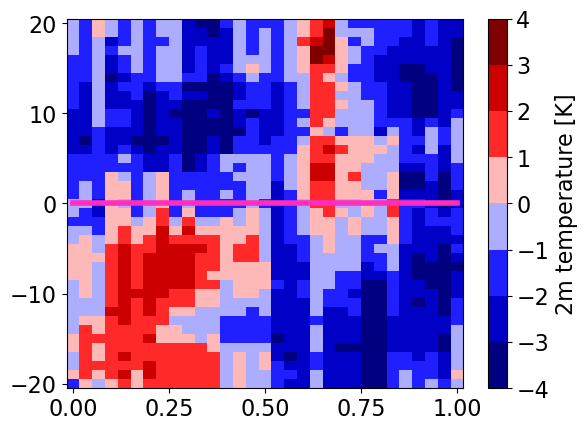

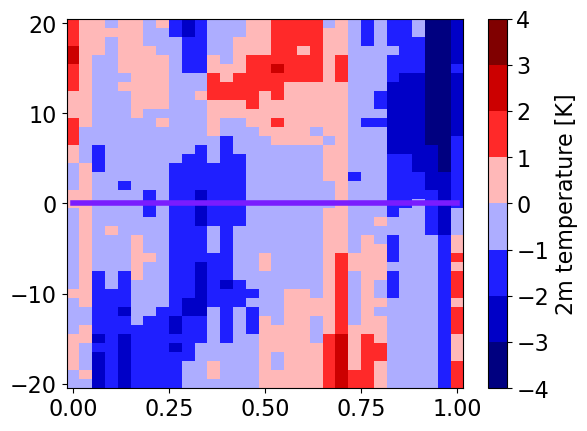

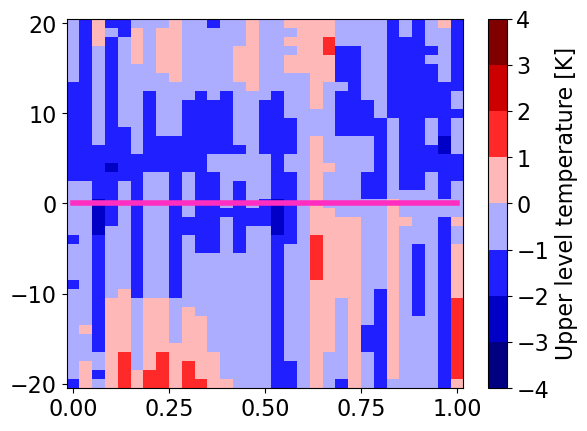

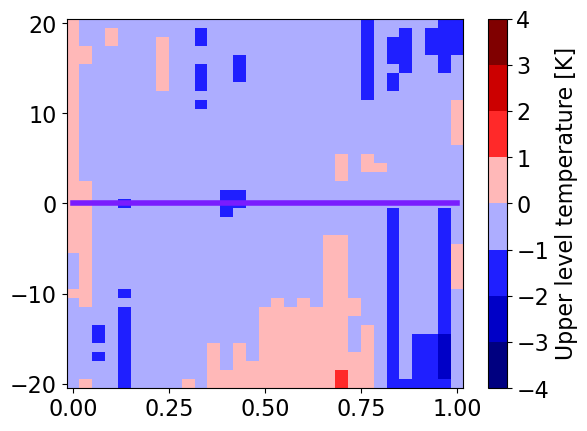

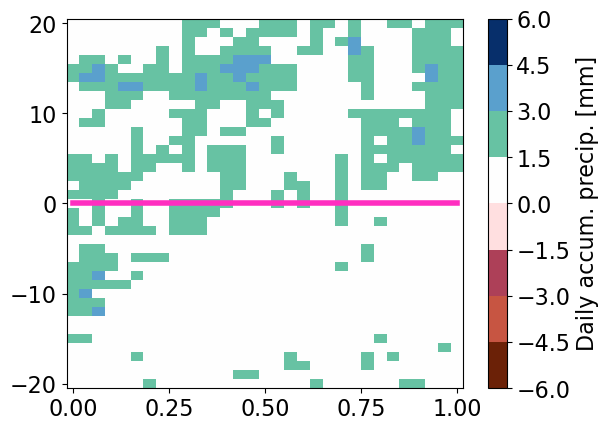

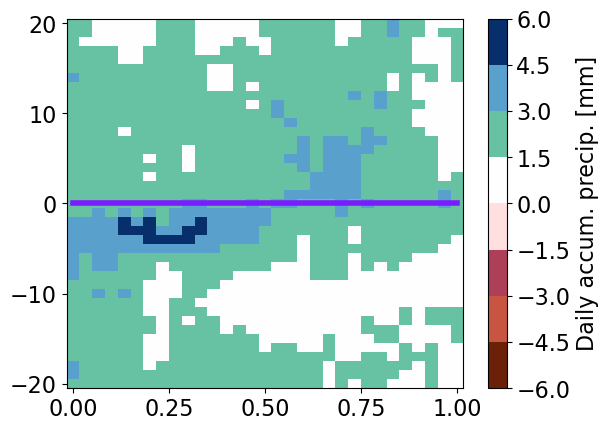

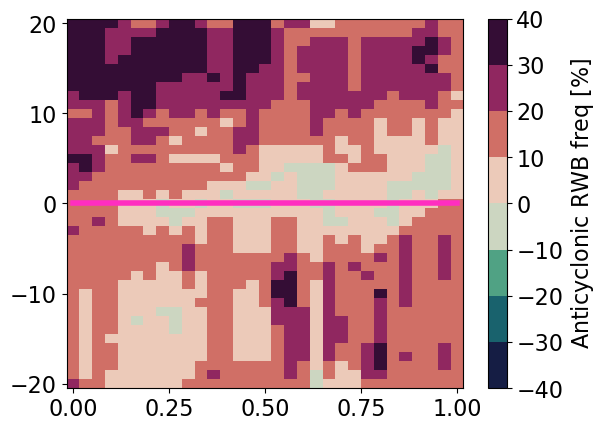

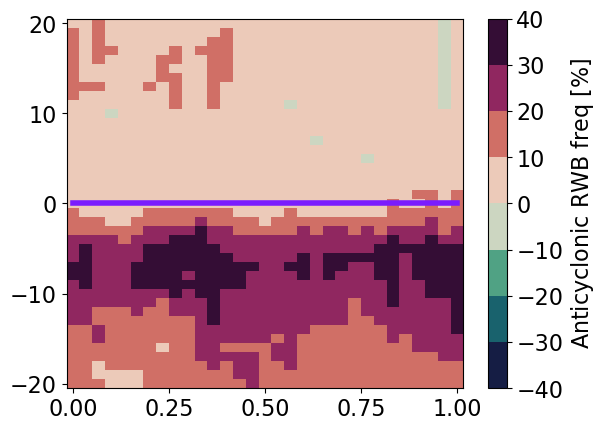

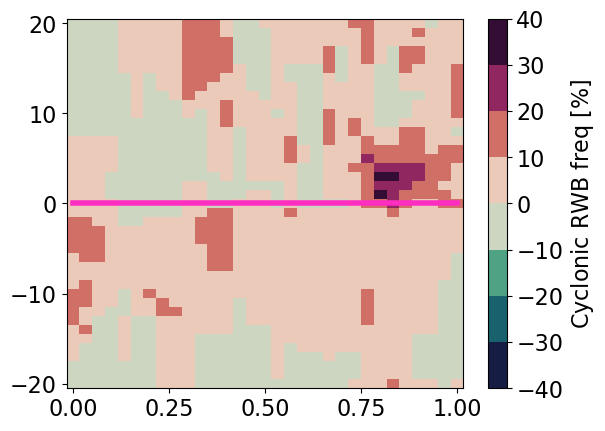

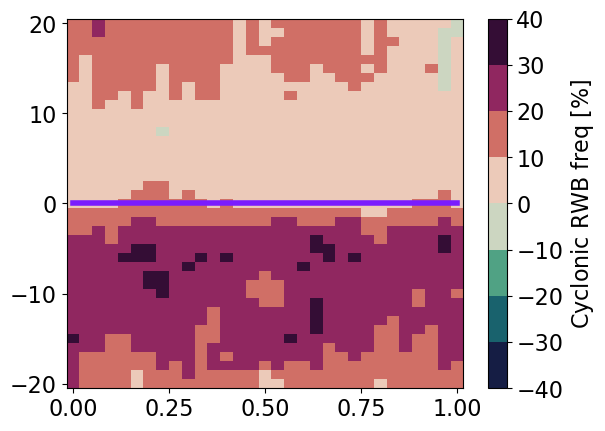

In [21]:
variable_dict = {
    "t2m": ["2m temperature [K]", 8, colormaps.BlWhRe, [-4, 4]],
    "t300": ["Upper level temperature [K]",8, colormaps.BlWhRe, [-4, 4]],
    "tp": ["Daily accum. precip. [mm]", 8, colormaps.precip4_diff_19lev, [-6, 6]],
    "apvs": [r"Anticyclonic RWB freq [$\%$]", 8, colormaps.curl, [-40, 40]],
    "cpvs": [r"Cyclonic RWB freq [$\%$]", 8, colormaps.curl, [-40, 40]],
}
to_plot = {
    varname: [
        xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_EDJ.nc"), engine="netcdf4"),
        xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_EDJ_pvals.nc"), engine="netcdf4"),
    ]
    for varname in variable_dict
}
clims = {
    varname: xr.open_dataarray(basepath_clim.joinpath(f"{varname}_relative_clim.nc"))
    for varname in to_plot
}
for varname in variable_dict:
    long_name, nlevels, cmap, [min_, max_] = variable_dict[varname]
    levels = MaxNLocator(nlevels).tick_values(min_, max_)
    norm = BoundaryNorm(levels, cmap.N)
    for spells_of in ["STJ", "EDJ"]:
        tplt = xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_{spells_of}.nc"), engine="netcdf4")
        pval = xr.open_dataarray(basepath.joinpath(f"{varname}_interp_spells_of_{spells_of}_pvals.nc"), engine="netcdf4")
        is_polar = spells_of == "EDJ"
        fig, ax = plt.subplots()
        im = ax.pcolormesh(tplt.norm_index, tplt.n, tplt.sel(is_polar=is_polar).values.T, shading="nearest", cmap=cmap, norm=norm)
        direction = infer_direction(tplt.sel(is_polar=is_polar))
        filter_ = symmetrize_p(pval.sel(is_polar=is_polar).T, direction, 0.05)
        # ax.pcolor(pval.norm_index, pval.n, pval.sel(is_polar=is_polar).T.where(filter_), hatch="xxx", alpha=0.0)

        ax.plot([0, 1], [0, 0], lw=4, color=COLORS[2 - int(is_polar)])
        
        fig.colorbar(im, label=long_name)